In [1]:
#weather forecasting data
import os

fname = "jena_climate_2009_2016.csv"

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print (header)
print (len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [5]:
import matplotlib.pyplot as plt


Bad key "ckend" on line 1 in
/Users/sichenglei/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#parsing the data, store in an array
import numpy as np

#data/time dun need to store
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [3]:
float_data.shape

(420551, 14)

Text(0, 0.5, 'temperature')

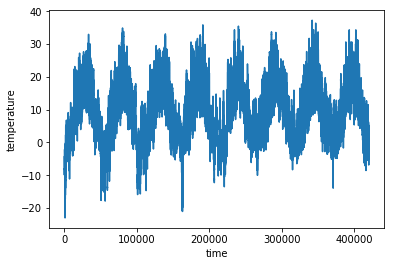

In [7]:
#plotting the temperature timeseries
#column <1> is T
temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)
plt.xlabel('time')
plt.ylabel('temperature')

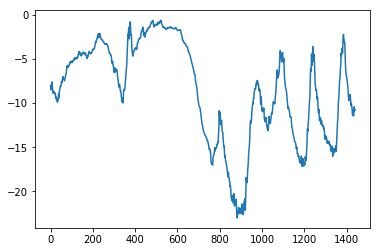

In [8]:
#first 10 days temperature
#every day has 144 data
plt.plot(range(1440), temp[:1440])

#easy to observe the periodity over months and days

In [9]:
'''
problem formulation:
given data going as far back as lookback timesteps (a timestep is 10 minutes)
and sampled every steps timesteps,
predict the temperature in delay timesteps
'''
#normalize the data
#use the first 200000 data only
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


In [10]:
#samples close together are very simialr (redundant)
#so we only take one data from each hour
## seq_len: lookback//step
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - 1 - delay 
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        #if not shuffle, then draw data in chronological order
        else:
            if i + batch_size >= max_index:
                #not enough fo ra new batch, restart
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), #==batch_size
                            lookback//step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(row-lookback, row, step)
            samples[j] = data[indices]
            targets[j] = data[row+delay][1]
        yield samples, targets
    
#every time you call the generator, will return the next group of data

In [11]:
#preparing the training, validation, and test generators
lookback = 1440
step = 6
delay = 144  #from the past 10 days to predict the next day
batch_size = 128

#only training data need to randomly select batch
train_gen = generator(float_data, 
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) / batch_size
test_steps = (len(float_data) - 300001 - lookback) /batch_size


In [20]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
from keras import layers
import keras

In [32]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',  
        patience=2 
        #interrupt training when val_acc has stopped improving for 1 epoch
    )
]

In [22]:
#GRU baseline
model = Sequential()
model.add(layers.SimpleRNN(32, input_shape=(None, float_data.shape[-1])))
#first RNN layer need to specify input_shape
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mse')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              callbacks=callbacks_list,
                              validation_data=val_gen,
                              validation_steps=100)


Epoch 1/20
500/500 [==============================] - 41s 81ms/step - loss: 0.1956 - val_loss: 0.1143
Epoch 2/20
500/500 [==============================] - 40s 81ms/step - loss: 0.1403 - val_loss: 0.1251


In [33]:
def auto_run():
    for op in ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']: 
        for seqlen in [6, 12, 24, 48, 96, 192]:
            lookback = 6*seqlen
            step = 6
            delay = 72  #from the past 10 days to predict the next half day
            batch_size = 128

            #only training data need to randomly select batch
            train_gen = generator(float_data, 
                                  lookback=lookback,
                                  delay=delay,
                                  min_index=0,
                                  max_index=200000,
                                  shuffle=True,
                                  step=step,
                                  batch_size=batch_size)

            val_gen = generator(float_data,
                                lookback=lookback,
                                delay=delay,
                                min_index=200001,
                                max_index=300000,
                                step=step,
                                batch_size=batch_size)

            test_gen = generator(float_data,
                                 lookback=lookback,
                                 delay=delay,
                                 min_index=300001,
                                 max_index=None,
                                 step=step,
                                 batch_size=batch_size)

            val_steps = (300000 - 200001 - lookback) / batch_size
            test_steps = (len(float_data) - 300001 - lookback) /batch_size

            #GRU baseline
            model = Sequential()
            model.add(layers.SimpleRNN(32, input_shape=(None, float_data.shape[-1])))
            #first RNN layer need to specify input_shape
            model.add(layers.Dense(1))

            model.compile(optimizer=op, loss='mse')
            history = model.fit_generator(train_gen,
                                          steps_per_epoch=500,
                                          epochs=20,
                                          callbacks=callbacks_list,
                                          validation_data=val_gen,
                                          validation_steps=100)
            
            loss = model.evaluate_generator(test_gen, test_steps)
            print ("------- Result --------")
            print ("Ops: {}, Seqlen: {}, loss: {}".format(op, seqlen, loss))
            




In [34]:
auto_run()

Epoch 1/20
500/500 [==============================] - 4s 8ms/step - loss: 0.2594 - val_loss: 0.1752
Epoch 2/20
500/500 [==============================] - 3s 7ms/step - loss: 0.2105 - val_loss: 0.1517
Epoch 3/20
500/500 [==============================] - 3s 7ms/step - loss: 0.1990 - val_loss: 0.1652
Epoch 4/20
500/500 [==============================] - 4s 7ms/step - loss: 0.1906 - val_loss: 0.1865
------- Result --------
Ops: sgd, Seqlen: 6, loss: 0.20251743928054763
Epoch 1/20
500/500 [==============================] - 6s 11ms/step - loss: 0.2441 - val_loss: 0.1441
Epoch 2/20
500/500 [==============================] - 5s 10ms/step - loss: 0.1761 - val_loss: 0.1221
Epoch 3/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1568 - val_loss: 0.1365
Epoch 4/20
500/500 [==============================] - 4s 8ms/step - loss: 0.1447 - val_loss: 0.1652
------- Result --------
Ops: sgd, Seqlen: 12, loss: 0.16320936894612761
Epoch 1/20
500/500 [==============================] - 7

Epoch 1/20
500/500 [==============================] - 30s 60ms/step - loss: 0.1672 - val_loss: 0.0951
Epoch 2/20
500/500 [==============================] - 27s 55ms/step - loss: 0.1200 - val_loss: 0.0898
Epoch 3/20
500/500 [==============================] - 26s 52ms/step - loss: 0.1102 - val_loss: 0.1014
Epoch 4/20
500/500 [==============================] - 29s 58ms/step - loss: 0.1062 - val_loss: 0.1003
------- Result --------
Ops: adagrad, Seqlen: 192, loss: 0.11133558117452158
Epoch 1/20
500/500 [==============================] - 5s 11ms/step - loss: 0.2539 - val_loss: 0.1767
Epoch 2/20
500/500 [==============================] - 4s 7ms/step - loss: 0.1802 - val_loss: 0.1179
Epoch 3/20
500/500 [==============================] - 4s 7ms/step - loss: 0.1649 - val_loss: 0.1405
Epoch 4/20
500/500 [==============================] - 4s 7ms/step - loss: 0.1547 - val_loss: 0.1565
------- Result --------
Ops: adadelta, Seqlen: 6, loss: 0.17596475762016517
Epoch 1/20
500/500 [==================

500/500 [==============================] - 11s 21ms/step - loss: 0.1116 - val_loss: 0.1092
Epoch 4/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1019 - val_loss: 0.0927
------- Result --------
Ops: adamax, Seqlen: 48, loss: 0.10243400410659849
Epoch 1/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2214 - val_loss: 0.1070
Epoch 2/20
500/500 [==============================] - 20s 40ms/step - loss: 0.1372 - val_loss: 0.0874
Epoch 3/20
500/500 [==============================] - 19s 38ms/step - loss: 0.1145 - val_loss: 0.0977
Epoch 4/20
500/500 [==============================] - 20s 40ms/step - loss: 0.1039 - val_loss: 0.1119
------- Result --------
Ops: adamax, Seqlen: 96, loss: 0.1099257526894672
Epoch 1/20
500/500 [==============================] - 41s 82ms/step - loss: 0.2312 - val_loss: 0.1100
Epoch 2/20
500/500 [==============================] - 37s 74ms/step - loss: 0.1248 - val_loss: 0.0952
Epoch 3/20
500/500 [==========================

In [25]:
model.evaluate_generator(test_gen, test_steps)

0.13929752193773456